In [2]:
library(randomForest)
library(tree)

library(doParallel)

library(rpart)
library(rpart.plot)

library(microbenchmark)

In [3]:
rmse = function(a,b){
    sqrt( mean((a - b)^2) )
}

In [4]:
citas = read.csv("data/ARIA_cleaned/citas.csv")

c_categ = c('ScheduledActivityCode', 'CityOrTownship', 'NStage', 'Technique', 'NoEditFlag_sch', 'NotificationPriorTimeFlag_sch', 'Site', 'NumberOfFractions_isNaN', 'InterfaceStamp', 'Intent', 'IsMorning', 'TechniqueSer', 'TStage', 'TumorSize_isNaN', 'SchedulableFlag', 'SimulationNeeded', 'DayOfWeek', 'NotificationPriorTime_a', 'SummaryStage', 'TreatmentIntentType', 'Sex', 'NotificationPriorTimeFlag_a', 'DiagnosisCode_sec', 'MStage', 'ActivityCategoryCode', 'NotificationPriorTime_sch', 'ObjectStatus_sec', 'Description', 'ResourceGroupSer', 'ActivityCode', 'FractionFrequency', 'ObjectStatus_planes', 'PlanNormMethod', 'ActualMachineSer', 'AssignableFlag', 'Status_pres', 'ClinicalStatus', 'PhaseType', 'PrimaryPTVSer_isNaN', 'SkinFlashMargin', 'PrescribedDose_isNaN', 'HistologyCode', 'DateOfBirth_isNaN', 'Status_rtpps', 'StartDelay_isNaN', 'CalcModelOptions', 'EquipmentSer', 'Bolus', 'AnchorActivityFlag', 'DiagnosisCode', 'DicomSeqNumber', 'NoEditFlag_cat', 'MultiFieldOptFlag', 'TreatmentOrientation', 'PatientStatus', 'Priority', 'Notes', 'EnergyModeSer')

citas[c_categ] <- lapply(citas[c_categ], factor)

y_s = citas$ScheduledDuration
citas[c("Duration","DefaultDuration","ScheduledDuration",'ScheduledActivitySer','StartDateTime',"ScheduledStartTime",
        "ScheduledEndTime","ActualStartDate","ActualEndDate")] = NULL

# citas = citas[citas$ActualDuration<60,]
# citas[c('CityOrTownship','Priority','PatientStatus','NotificationPriorTimeFlag_sch','NotificationPriorTimeFlag_a',
#         'NotificationPriorTime_a','SkinFlashMargin')] = NULL

dim(citas)

[1] 76881    72

In [5]:
y = citas$ActualDuration
x = citas[setdiff(names(citas), "ActualDuration")]

x = x[y<40,]
y = y[y<40]

In [6]:
n <- nrow(x)
r = 0.7

# set.seed(17)
# i <- sample(1:n, round(r*n))
i = seq(1,round(r*n))
j <- setdiff(1:n, i)

x_tr = x[i,]
y_tr = y[i]

x_te = x[j,]
y_te = y[j]

dim(x_tr)
dim(x_te)

[1] 52884    71

[1] 22664    71

# Random Forest

### Parallel

In [8]:
randomForest2 = function(ntree, mtry, sampsize, maxnodes){
    randomForest(x = x_tr, y = y_tr,
                      ntree = ntree,
                      mtry = mtry,
                      
                      replace = FALSE,
                      sampsize = sampsize,
                      
                      maxnodes = maxnodes,  # max 3500
                      
#                       importance = TRUE,
                    )
}

no_cores <- detectCores(logical = TRUE)
print(no_cores)
cl <- makeCluster(no_cores) # -1
registerDoParallel(cl)
clusterExport(cl, c('randomForest2','randomForest', 'x_tr', 'y_tr'))

[1] 8


### Optimización

In [ ]:
ntrees = rep(10,7) # 9 x 7
mtry = 30 # seq(1,40,1) # 
rel_sampsize = seq(0.01,0.35,0.01) # 0.25
maxnodes = 150 # seq(5,200,5) # 150

rmse_tr = c(); rmse_te = c(); cor_tr = c(); cor_te = c()
for(v1 in mtry){
    for(v2 in rel_sampsize){
        for(v3 in maxnodes){
            cat(v1,v2,v3,"\n")
            flush.console()

            rfs = parLapply(cl, ntrees, fun = randomForest2,
                            mtry = v1,
                            sampsize = ceiling(nrow(x_tr)*v2), 
                            maxnodes = v3)

            rf_comb = combine(rfs[[1]], rfs[[2]], rfs[[3]], rfs[[4]], rfs[[5]], rfs[[6]], rfs[[7]])
            
            y_pred <- predict(rf_comb, x_tr)
            rmse_tr = c(rmse_tr, rmse(y_tr, y_pred))
            cor_tr  = c(cor_tr, cor(y_tr, y_pred, method = "pearson"))
            
            y_pred = predict(rf_comb, x_te)
            rmse_te = c(rmse_te, rmse(y_te, y_pred))
            cor_te  = c(cor_te, cor(y_te, y_pred, method = "pearson"))
        }
    }
}

In [ ]:
variable = rel_sampsize

options(repr.plot.width = 6, repr.plot.height = 6)
plot(variable, rmse_tr, col="blue", type="l", xlab = "sampsize", ylab="RMSE", ylim=c(6,8), cex.lab=1.4, lwd=2)

lines(variable, rmse_te, col="red", lwd=2)
legend(0.05, 6.3, legend=c("train", "test"),
       col=c("blue", "red"), lty=1, cex=1.2)

plot(variable, cor_tr,  col="blue", type="l", xlab = "sampsize", ylab="Cor Pearson", ylim=c(0.68,0.8), cex.lab=1.4, lwd=2)
lines(variable, cor_te, col="red", lwd=2)
legend(0.05, 0.79, legend=c("train", "test"),
       col=c("blue", "red"), lty=1, cex=1.2)

### microbenchmark

In [32]:
aux = function(trees){ # 30 s (60 trees)
    microbenchmark(parLapply(cl, trees, fun=randomForest2,mtry = 30,sampsize = ceiling(nrow(x_tr)*0.25),maxnodes = 150),
    times=3)$time
}

# aux = function(trees){ # 245 s (60 trees)
#     microbenchmark(parLapply(cl, trees, fun=randomForest2,mtry = 50,sampsize = ceiling(nrow(x_tr)*0.35),maxnodes = 500),
#     times=3)$time
# }


n=1
cat("0\n")
flush.console()
tiempos1 = aux( rep(60,1)*n )
ref = median(tiempos1) # ns
print(ref/1e9)
cat("1\n")
flush.console()
tiempos2 = aux( rep(30,2)*n )
cat("2\n")
flush.console()
tiempos3 = aux( rep(20,3)*n )
cat("3\n")
flush.console()
tiempos4 = aux( rep(15,4)*n )
cat("4\n")
flush.console()
tiempos5 = aux( rep(12,5)*n )
cat("5\n")
flush.console()
tiempos6 = aux( rep(10,6)*n )
cat("6\n")
flush.console()
tiempos7 = aux( c(9,9,9,9,8,8,8)*n )
cat("7\n")
flush.console()
tiempos8 = aux( c(8,8,8,8,7,7,7,7)*n )

0
[1] 3.950245
1
2
3
4
5


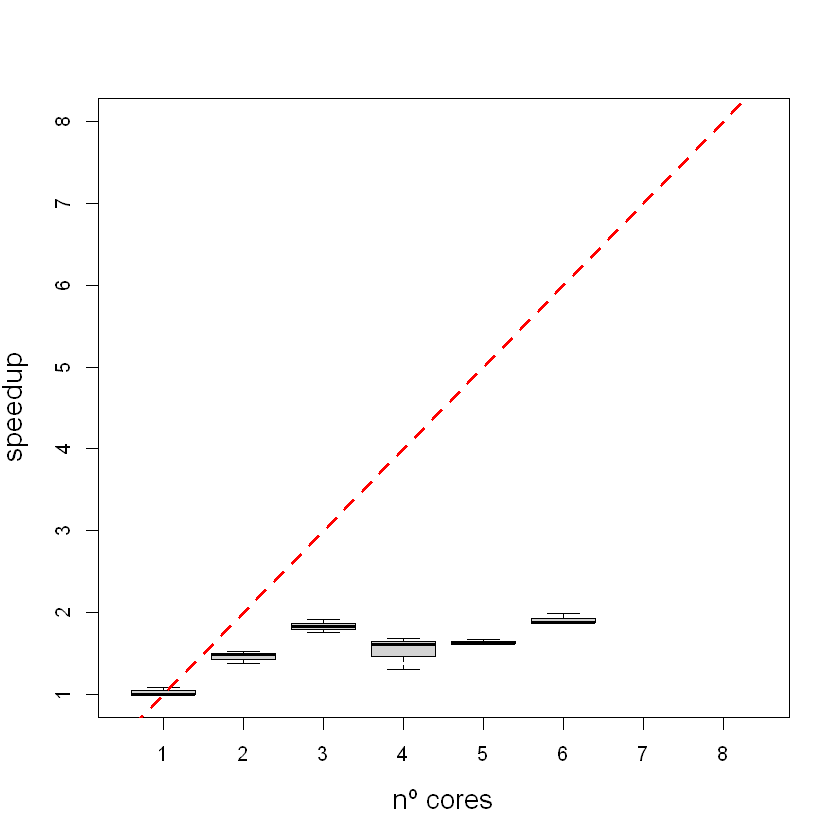

In [33]:
boxplot(ref/tiempos1,
        ref/tiempos2,  
        ref/tiempos3,  
        ref/tiempos4,  
        ref/tiempos5,  
        ref/tiempos6,  
        ref/tiempos7,  
        ref/tiempos8,  
        ylab = "speedup", xlab="nº cores", cex.lab=1.4, ylim=c(1,8), names=c(1,2,3,4,5,6,7,8) )
abline(a=0, b=1, col="red", lwd=3, lty=2)

### Un solo random forest

In [10]:
model1 = randomForest(x = x_tr, y = y_tr,
                      ntree = 70,
                      mtry = 30,
                      
                      replace = FALSE,
                      sampsize = ceiling(nrow(x_tr)*0.25),
                      
                      maxnodes = 150,  # max 3500
                      
                      importance = TRUE,
                    )

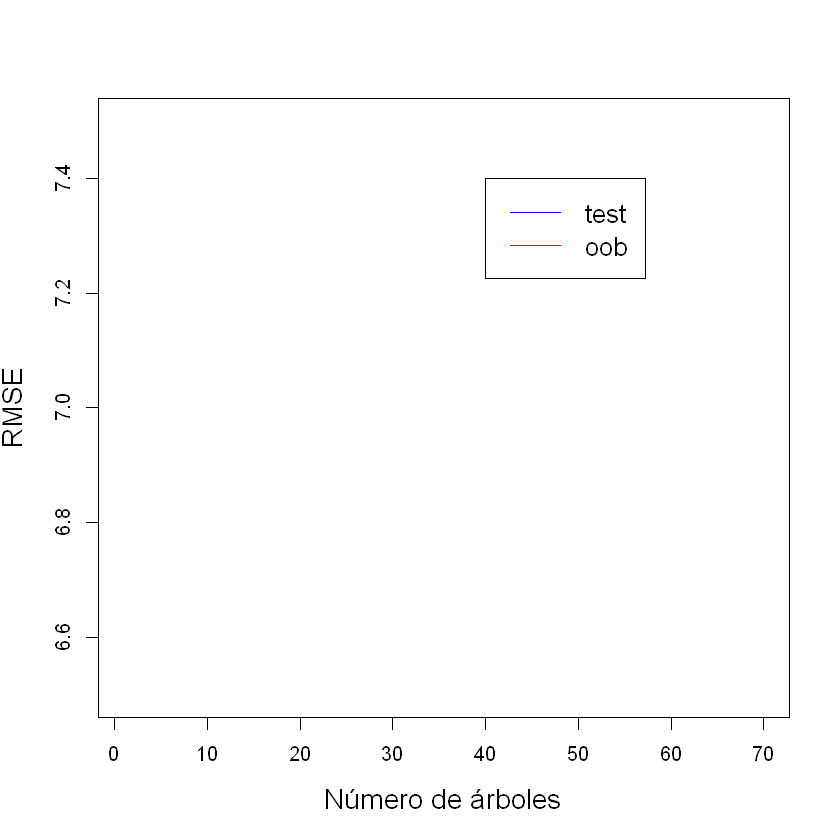

In [11]:
y_pred_all = predict(model1, x_te, predict.all = TRUE)
mat = y_pred_all$individual
aa = t(apply(mat, 1, cumsum) / seq(ncol(mat)))

rmse_te = c()
for(i2 in 1:70){
    rmse_te = c(rmse_te, rmse(y_te, aa[,i2]))
}

plot(rmse_te, xlab='Número de árboles', ylab='RMSE', cex.lab=1.4, ylim=c(6.5,7.5), type="l", lwd=3, col="blue")
points(sqrt(model1$mse), type="l", lwd=3, col="red")

legend(40, 7.4, legend=c("test", "oob"),
       col=c("blue", "red"), lty=1, cex=1.3)

rmse =  4.506286 
cor pearson =  0.6946007 
rmse =  4.739532 
cor pearson =  0.6315173 


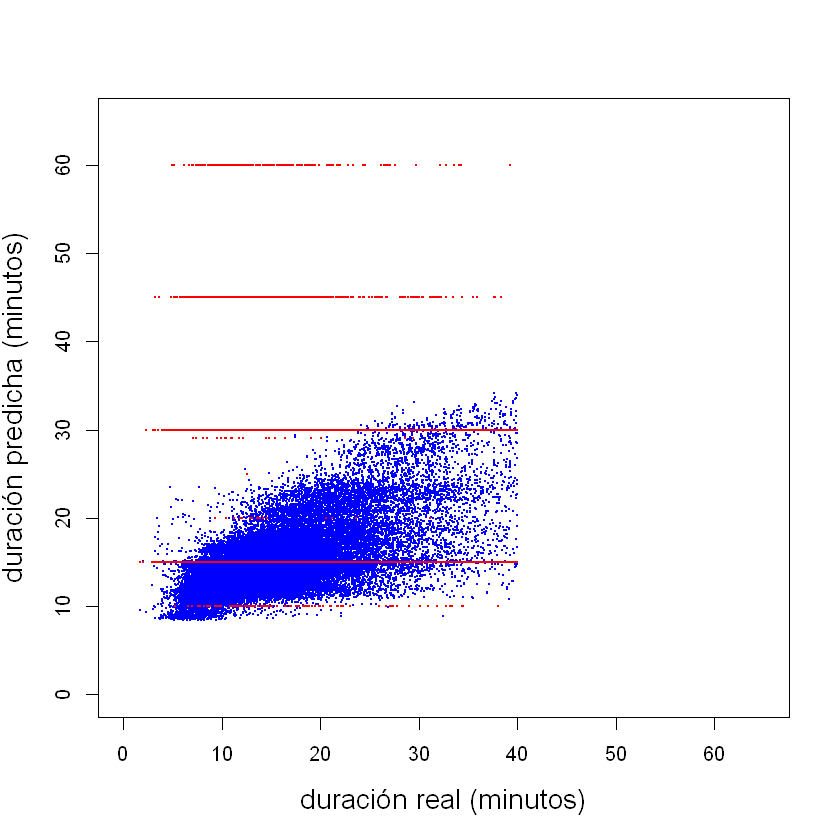

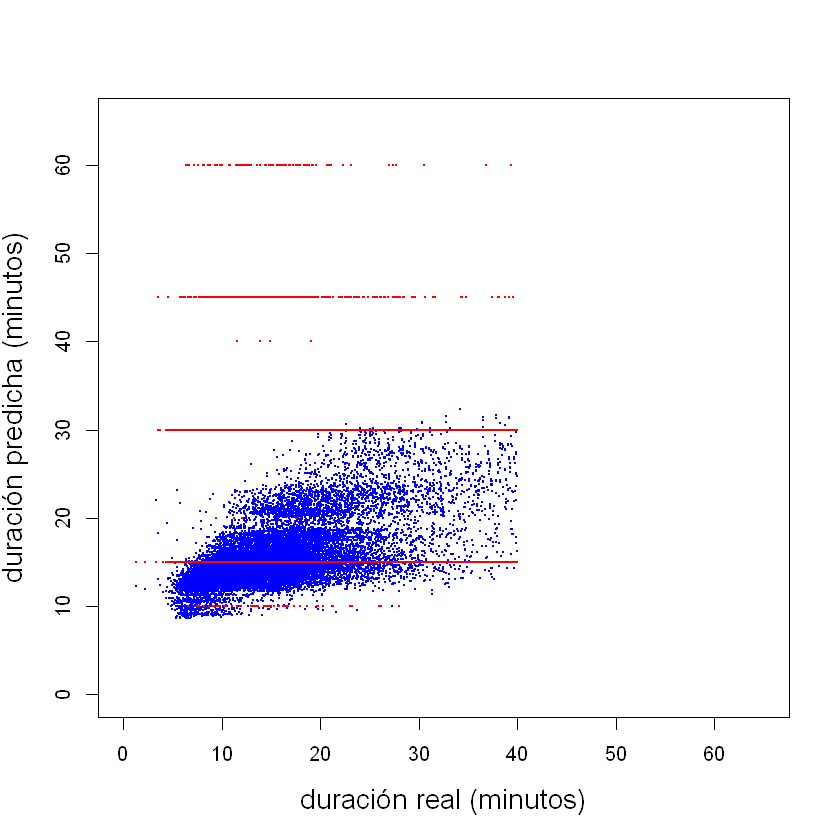

In [12]:
y_pred = predict(model1, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")
plot(y_tr, y_pred, xlim=c(0,65), ylim=c(0,65), pch=20, cex = 0.1, xlab = 'duración real (minutos)', 
     ylab='duración predicha (minutos)', cex.lab=1.4, col="blue")
points(y_tr, y_s[i], col="red", pch=20, cex = 0.1)

y_pred = predict(model1, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")
plot(y_te, y_pred, xlim=c(0,65), ylim=c(0,65), pch=20, cex = 0.1, xlab = 'duración real (minutos)', 
     ylab='duración predicha (minutos)', cex.lab=1.4, col="blue")
points(y_te, y_s[j], col="red", pch=20, cex = 0.1)

### Importance

In [45]:
df = model1$importance
df2 = data.frame( "%IncMSE" = df[order(df[,"%IncMSE"], decreasing = TRUE),"%IncMSE"] )
df2

,X.IncMSE
,<dbl>
NumPlans,8.99198810
NumFields,7.34635947
ActivityCode,4.95722655
EquipmentSer,3.39165455
DiagnosisCode,2.31937682
EnergyModeSer,2.25557815
TimesHasCome,1.71354507
PrescribedDose,1.43918914
TechniqueSer,1.19711044


In [41]:
df = model1$importance
data.frame( "IncNodePurity" = df[order(df[,"IncNodePurity"], decreasing = TRUE),] )

,IncNodePurity
,<dbl>
NumPlans,48617.9299
ActivityCode,27085.9416
NumFields,25476.9359
TimesHasCome,16083.2428
EquipmentSer,14308.3331
DiagnosisCode,12472.9927
PrescribedDose,10431.7432
EnergyModeSer,8878.8571
CityOrTownship,5281.7257


# Single tree

In [80]:
rownames(df2)[1:13]

[1] "NumPlans"            "NumFields"           "ActivityCode"       
 [4] "EquipmentSer"        "DiagnosisCode"       "EnergyModeSer"      
 [7] "TimesHasCome"        "PrescribedDose"      "TechniqueSer"       
[10] "NoEditFlag_sch"      "TreatmentIntentType" "SummaryStage"       
[13] "ActualMachineSer"

In [81]:
# citas[,df2]
cols = c(rownames(df2)[1:13] , "ActualDuration")

In [92]:
trc = tree.control(length(y_tr), minsize = 50, mindev = 0.01)
model3 = tree(ActualDuration~. , citas[,cols], subset=i, control = trc)

y_pred = predict(model3, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")

y_pred = predict(model3, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")

rmse =  5.453602 
cor pearson =  0.5093818 
rmse =  5.526887 
cor pearson =  0.5003056 


In [93]:
# plot(y_te, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20)

In [99]:
data.frame("categoría"=levels(citas$ActivityCode), "letra"=letters[1:20])

categoría,letra
<chr>,<chr>
Braquiterapia,a
Cambio de tÃ©cnica,b
Cambio horario,c
Compensacion,d
Daily Treatment,e
Dosis Ãºnica,f
Fin Tratamiento,g
ICT,h
Inicio SBRT Exactrac,i


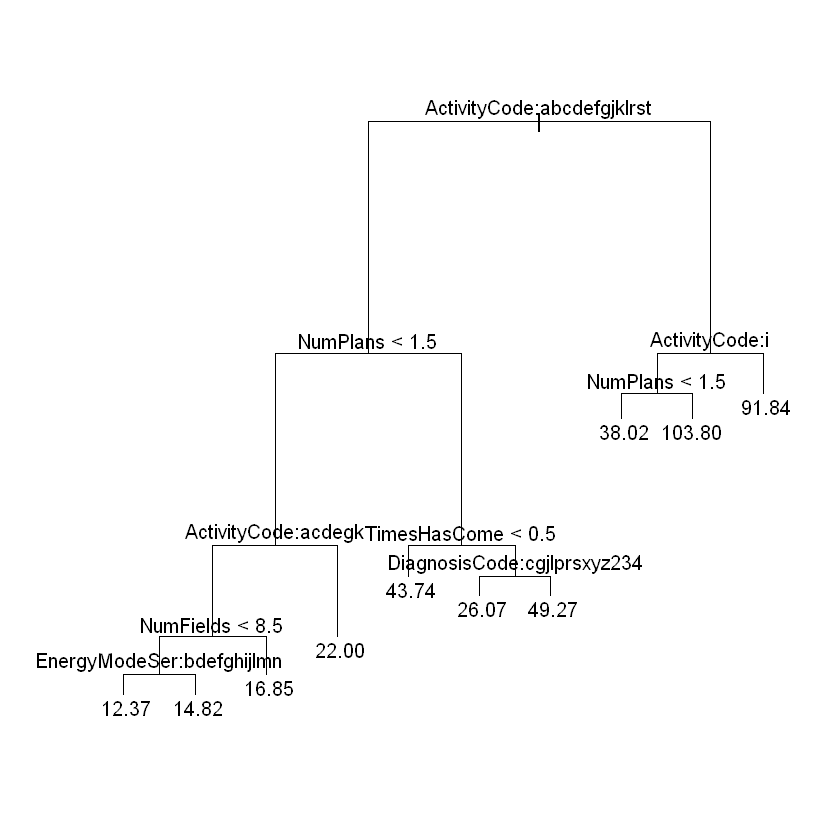

In [95]:
plot(model3)
text(model3)

In [ ]:
# opt
rmse_tr = c()
rmse_te = c()


minsizes = 4
mindevs = 0.01

for(minsize in minsizes){
    for( mindev in mindevs){
        trc = tree.control(length(y_tr), minsize = minsize, mindev = mindev)
        aux = tree(ActualDuration~. , citas, subset=i, control = trc)

        cat(minsize,'\n')
        flush.console()

        y_pred = predict(aux, x_tr)
        rmse_tr = c(rmse_tr, rmse(y_tr, y_pred))

        y_pred = predict(aux, x_te)
        rmse_te = c(rmse_te, rmse(y_te, y_pred))

        
        
    }
}
plot(rmse_tr, col="blue", ylim=c(6.5,10))
points(rmse_te, col="red")

### rpart

In [ ]:
trc = tree.control(length(y_tr), minsize = 2, mindev = 0.01)
model4 = rpart(ActualDuration~. , citas, subset=i, control = trc)

In [ ]:
y_pred = predict(model4, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")

y_pred = predict(model4, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)
rpart.plot(model4)
# text(model4)